# <center> **Классификация клиентов банка**

В датасете представлены данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Решение задачи поможет поднять доходы банка и понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

>Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

>Техническая задача: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.


In [102]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import optuna 

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics, preprocessing 
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.preprocessing  import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score

## <center> **1. Предобработка данных**

In [2]:
# Загрузим данные
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


+ Данные о клиентах банка:

    + age (возраст);
    + job (сфера занятости);
    + marital (семейное положение);
    + education (уровень образования);
    + default (имеется ли просроченный кредит);
    + housing (имеется ли кредит на жильё);
    + loan (имеется ли кредит на личные нужды);
    + balance (баланс).

+ Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

    + contact (тип контакта с клиентом);
    + month (месяц, в котором был последний контакт);
    + day (день, в который был последний контакт);
    + duration (продолжительность контакта в секундах).

+ Прочие признаки:

    + campaign (количество контактов с этим клиентом в течение текущей кампании);
    + pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    + previous (количество контактов до текущей кампании)
    + poutcome (результат прошлой маркетинговой кампании).

+ Целевая переменная
    + deposit, которая определяет, согласится ли клиент открыть депозит в банке.

In [3]:
# Посмотрим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# Определим в каких признакех есть пропуски
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Метод isnull() показал пропущенные значения только в признаке 'balance'. Но они могут быть скрыты другими значениями. Проверим признак 'job'.

In [5]:
# Посмотрим какие категории и в каком количестве представлены в категориальных признаках
for value in df.columns:
    if df[value].dtype == 'object':
        print(value)
        print('_'*20)
        print(df[value].value_counts())
        print('-'*60)

job
____________________
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
------------------------------------------------------------
marital
____________________
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
------------------------------------------------------------
education
____________________
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
------------------------------------------------------------
default
____________________
no     10994
yes      168
Name: default, dtype: int64
------------------------------------------------------------
balance
____________________
0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $   

In [6]:
# Преобразуем признак 'balance' в тип float для чего сначала уберем лишние символы
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype('float64')
print(f'Уникальные значения в признаке баланс {df["balance"].unique()}')

Уникальные значения в признаке баланс [2343.   45. 1270. ... 1594. 2593. -134.]


In [7]:
# Заменим пропуски в признаке 'balance' на медианное значение в этом признаке
print(f'Медианное значение в признаке "balance": {df["balance"].median()}')
df = df.fillna({'balance' : df['balance'].median()})

Медианное значение в признаке "balance": 550.0


Пропуски в категориальных признаках 'job' и 'education' находятся под значением 'unknown'. Заменим их на модальное значение в соответствующих признаках.

In [8]:
# Выведем модальное значение признака job
print(f'Модальное значение в признаке "job": {df["job"].mode()[0]}')
# Заменяем пропуски в признаке
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
# Выведем модальное значение признака education
print(f'Модальное значение в признаке "education": {df["education"].mode()[0]}')
# Заменяем пропуски в признаке
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

Модальное значение в признаке "job": management
Модальное значение в признаке "education": secondary


Рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 

In [9]:
mask = df[(df['job'] == df['job'].value_counts().nlargest(1).index[0]) & (df['education'] == df['education'].value_counts().nlargest(1).index[0])]
round(mask['balance'].mean(), 2)

1598.88

Удалим выбросы для признака 'balance', используя метод межквартильного размаха. Для этого напишем функцию def outliers_iqr

In [17]:
def outliers_iqr(data, feature, left=1.5, right=1.5):
    """Функция определяет выбросы по 
    методу межквартильного размаха Тьюки.

    Args:
        data (_type_): dataframe
        feature (_type_): столбец таблицы, по которому
        производится вычисление
        left (float, optional): Левая граница межкваритльного размаха. Defaults to 1.5.
        right (float, optional): Правая граница межквартильного размаха. Defaults to 1.5.
        log_scale: логарифмирование (True or False). Default False.
        
    Returns:
       outliers - датафрейм с выбросами
       cleaned - датафрейм с очищенными данными
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    print('lower_bound:', lower_bound) # Нижняя граница
    upper_bound = quartile_3 + (iqr * right)
    print('upper_bound:', upper_bound) # Верхняя граница
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

# Вызовем функцию для определения выбросов
# outliers - датафрейм с выбросами
# cleaned - очищенный датафрейм
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

lower_bound: -2241.0
upper_bound: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


In [19]:
# Размерность очищенного датафрейма
cleaned.shape

(10104, 17)

## <center> **2.  Разведывательный анализ**

### 2.1. Изучим соотношение классов на предмет сбалансированности

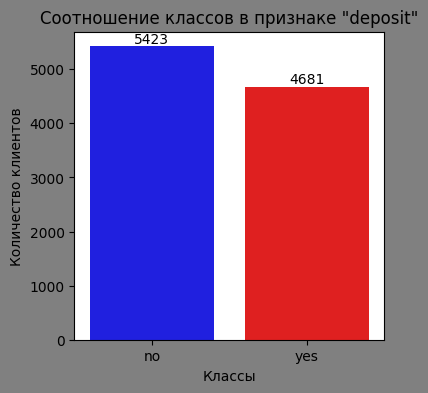

In [20]:
# Постороим график соотношения значений в целевом признаке 'deposit'
deposit = cleaned['deposit'].value_counts().reset_index().rename(columns={'index' : 'deposit', 'deposit' : 'count'})
plt.figure(figsize=(4, 4), facecolor='gray')
bar = sns.barplot(deposit, x='deposit', y='count', palette=['blue', 'red'])
bar.set_title('Соотношение классов в признаке "deposit"');
bar.set_xlabel('Классы');
bar.set_ylabel('Количество клиентов');
bar.bar_label(bar.containers[0]);


Судя по графику, классы 'yes' и 'no' в признаке сбалансированы, что позволит построить модель классификации без дополнительных преобразований.

### 2.2. Количественные переменные.

In [21]:
# Посмотрим описательную статистику количественных признаков
cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10104.0,40.895487,11.735511,18.0,32.0,38.0,48.00,95.0
balance,10104.0,807.331354,993.673452,-2049.0,95.0,444.5,1224.75,4062.0
day,10104.0,15.590657,8.441852,1.0,8.0,15.0,22.00,31.0
duration,10104.0,368.777712,346.650712,2.0,137.0,252.0,490.00,3881.0
campaign,10104.0,2.516924,2.707180,1.0,1.0,2.0,3.00,43.0
pdays,10104.0,51.307700,109.643031,-1.0,-1.0,-1.0,2.00,854.0
previous,10104.0,0.816112,2.243875,0.0,0.0,0.0,1.00,58.0


Построим гистограмму и boxplot для числовых признаков

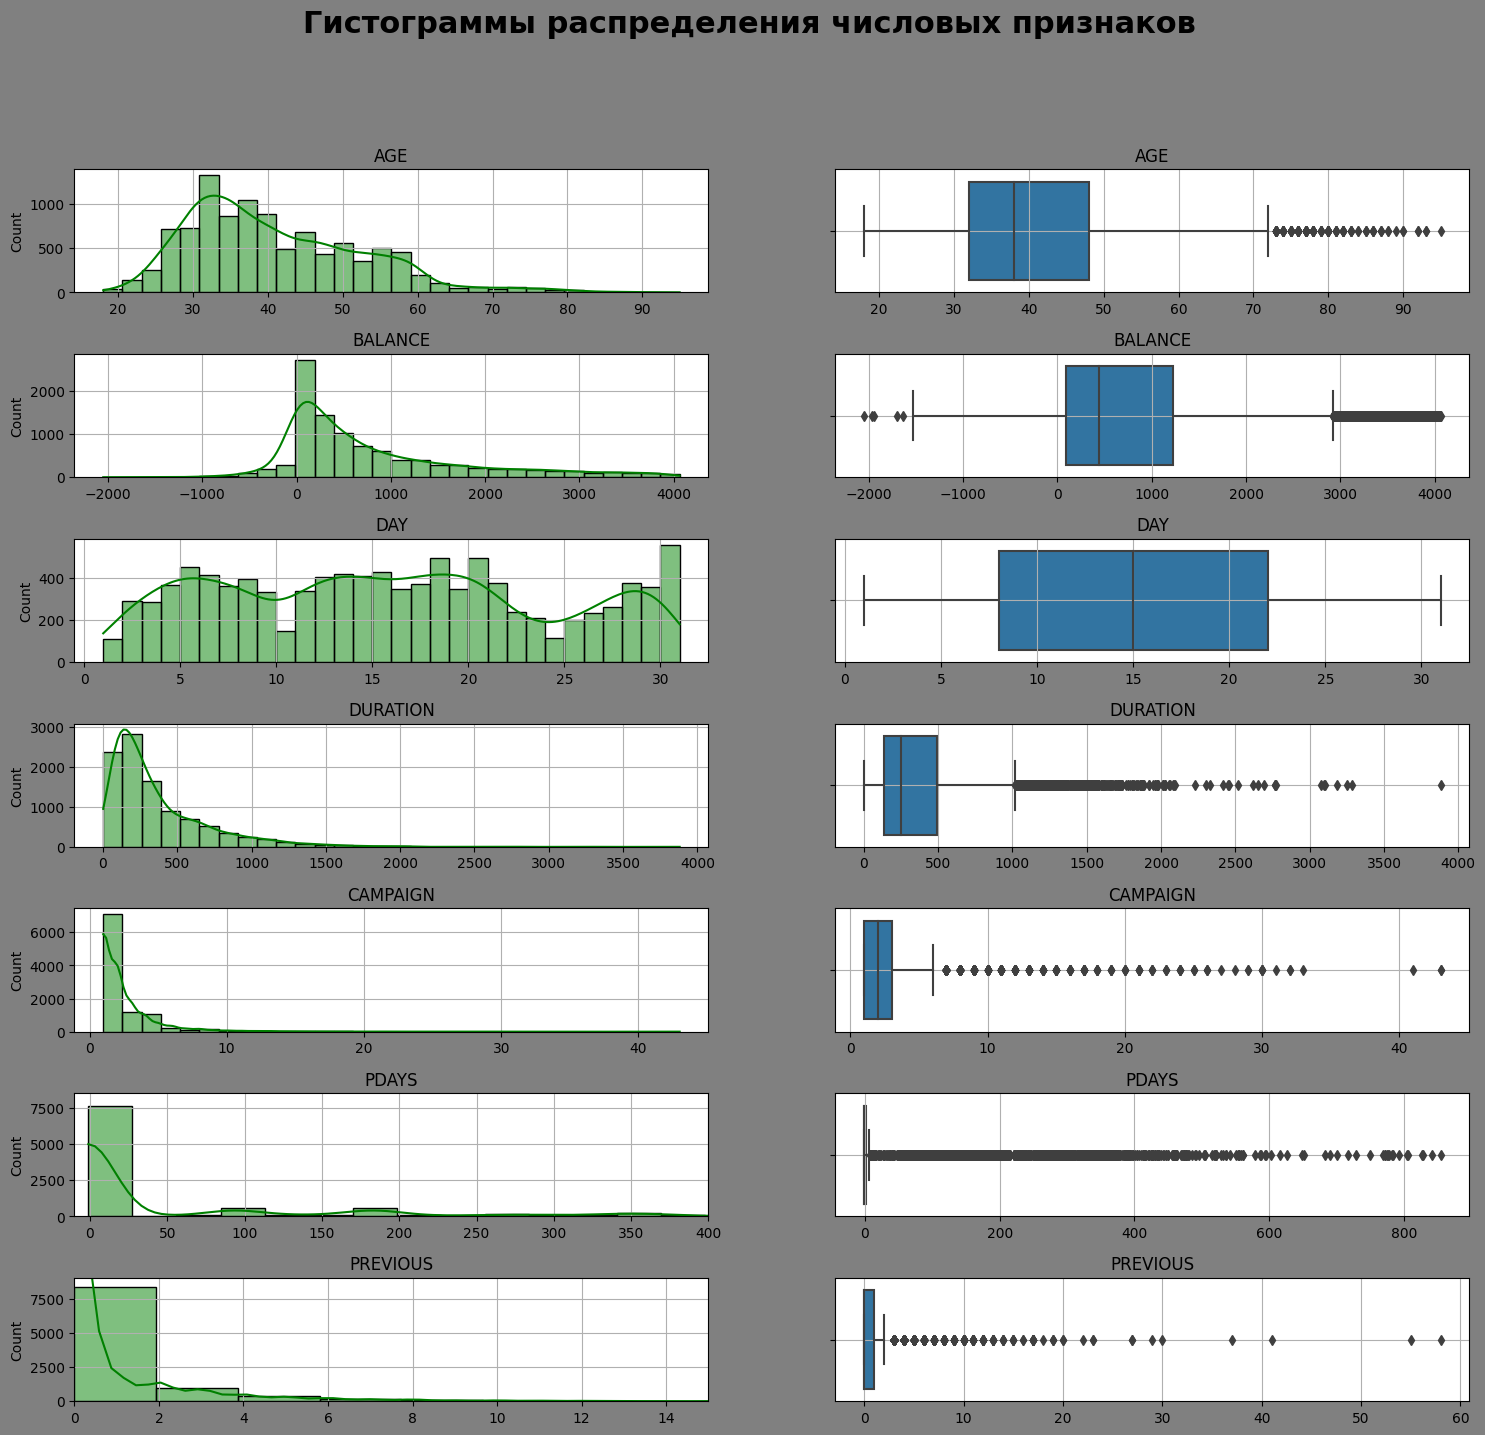

In [22]:
# Составим список из названий числовых признаков
col_list = list(cleaned.describe().T.index)
n = len(col_list) # Длина списка
# Поле для графиков из двух столбцов и количеством строк, 
# равным длине col_list
fig, axes = plt.subplots(n, 2,  figsize=(18, 16), facecolor='gray')
fig.suptitle('Гистограммы распределения числовых признаков',
             fontsize=22,
             fontweight='bold')
plt.subplots_adjust(hspace=0.5)
# Пройдем циклом по списку признаков и построим для каждого график
for i, col in enumerate(col_list):
    # Гистограмма
    histplot = sns.histplot(cleaned,
                            x=col,
                            bins=30,
                            color='green',
                            kde=True,
                            ax=axes[i][0])
    histplot.set_title(col.upper())
    histplot.set_xlabel('')
    histplot.grid()
    # Boxplot
    boxplot = sns.boxplot(cleaned, x=col, ax=axes[i][1])
    boxplot.set_title(col.upper())
    boxplot.set_xlabel('')
    boxplot.grid()

# Для более наглядного отображения задаем лимиты осей координат гистограммам 5 и 6
axes[5][0].set_xlim(-10, 400)
axes[5][0].set_ylim(0, 8500)
axes[6][0].set_xlim(0, 15) 
axes[6][0].set_ylim(0, 9000);  

В датасете представлены 7 числовых признаков: возраст; баланс; день контакта в маркетинговую кампанию; продолжительность в секундах; количество контактов, количество пропущенных дней с момнента последней кампании; количество контактов до текущей кампании.
По признаку "Age" на момент маркетинговой кампании возраст клиентов банка находится в промежутке от 18 до 95 лет. Данные клиентов старше 70 лет можно отнести к категории аномальных значений. Большая часть клиентов банка в возрасте до 40 лет, модальное значение в районе 33-35 лет. От 40 до 60 клиентов меньше, распределены они равномерно. После отметки 60 лет наблюдается спад. Таким образом, большая часть клиентов банка - это работающие специалисты с высшим образованием, так как резкий рост числа клиентов начинается в возрасте 25 лет, когда присходит выпуск из высшего учебного заведения. Это люди, которые относятся к категории молодых специалистов (до 35 лет), которые еще не заняли высокие управленческие должности.

Распределение по признаку "Баланс" логнормальное, оно хорошо демонстрирует доходность активов. Виден отрицательный баланс до -2049$, но большая его часть все-таки до -1000$. У большего количества вкладчиков баланс до 200$, затем разко снижается количество вкладчиков относительно баланса. Медианное значение в районе 400-500$. Также в признаке наблюдаются аномальные значения с двух сторон. В банках США депозит - это срочный вклад с повышенным процентом. Но если средства снимаются досрочно, то вкладчику начисляется штраф. С этим может быть также связан отрицательный баланс счета. Небольшие суммы вкладов на короткий срок под повышенный процент соответствуют портрету клиента, описанному в признаке "Возраст".

Следующие признаки связаны с маркетиноговой кампанией банка.

Признак "Day" - день, в который был последний контакт. Соответствуют дню месяца. Распределение в признаке равномерное. Наблюдаются небольшие спады, что, видимо, связано с днями подготовки отчетности в банке. Резкий подъем работы с клиентами в конце и начале месяца.

В признаке "Duration" - продолжительность общения с клиентом в секундах. Распределение признака логнормальное. Минимальная продолжительность - 2 секунды. Более 2000 контактов длится до 60 секунд. Можно предположить, что данные клиенты отказались от разговора. Модальное значение в районе 200-250 секунд. Это та продолжительность времени, которую готовы уделить клиенты этой категории для общения по вопросам кампании. Потому что большая часть контактов, судя по признаку "Day" совершается в рабочее время. После этой отметки резкий спад продолжительности контакта. Самое длительное общение 3381 секунда, что соответствует 56 минутам. В признаке также много выбросов. 

В признаке "Campaign" количество контактов с клиентов в течение текущей маректинговой кампании. Большая часть контактов = 1, медианное значение на отметке - 2. С несколькими клиентами понадобилось 3 контакта. Максимальное значение в признаке - 43. Звонки клиенту больше 6 раз можно отнести к категории выбросов. 2-6 звонков возможно связано с тем, что менеджер перезванивал клиенту в более удобное время.

Признак "pdays" количество пропущенных дней с момента последней маркетинговой кампании. Здесь минимальное и медианное значения совпадают = -1. То есть не было пропусков в контакте с клиентами. Максимальное значение 854.

Признак "Previous" содержит информацию о количестве контактов с клиентом до текущей кампании. Минимальное и медианное значение совпадают и равны 0. Это говорит о том, что 50% - это новые клиенты банка, которые на попадали под предыдущие маркетинговые кампании. Максимальное значение 58. Можно говорить о том, что только у банка 25% клиентов долгосрочно выбирают этот депозит. Стоит обратить внимание на вероятный отток клиентов из банка.

Признаки "balance", "duration", "pdays" имеют большой разброс в значениях.

### 2.3. Категориальные переменные

Построим графики распределения категориальных признаков

In [24]:
# Посмотрим их описательные статистики
cleaned.describe(include='object').T

,count,unique,top,freq
job,10104,11,management,2314
marital,10104,3,married,5714
education,10104,3,secondary,5517
default,10104,2,no,9938
housing,10104,2,no,5243
loan,10104,2,no,8711
contact,10104,3,cellular,7282
month,10104,12,may,2616
poutcome,10104,4,unknown,7570
deposit,10104,2,no,5423


Построим Barplot для каждого признака.

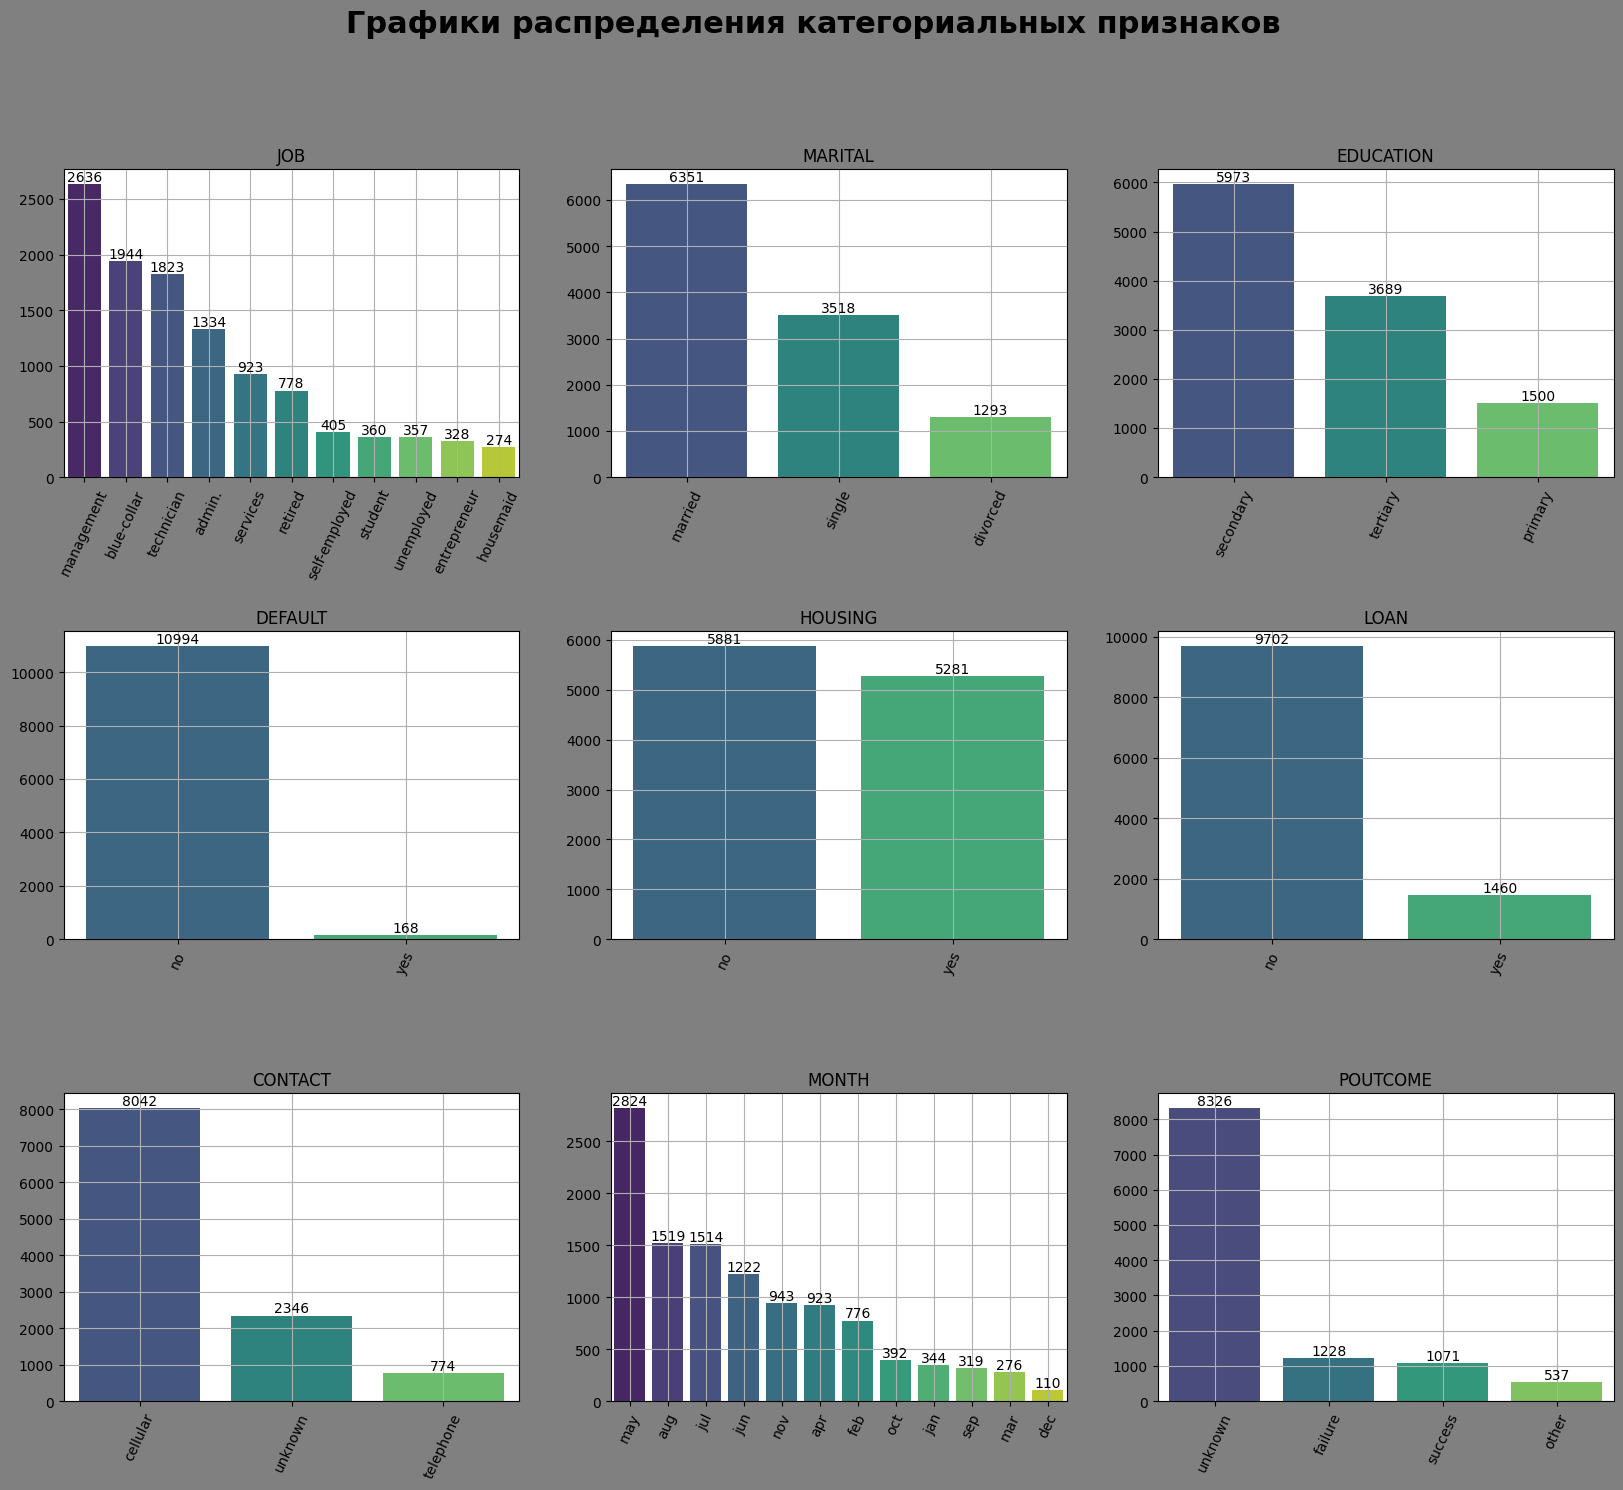

In [25]:
# Список категориальных признаков
features = list(cleaned.describe(include='object').T.index)
# Исключаем признак 'deposit', так как его рассмотрели в пункте 2.1.
features.remove('deposit')
# Создаем поле для графиков 3х3.
fig, axes = plt.subplots(3, 3, figsize=(20, 16), facecolor='gray')
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Графики распределения категориальных признаков',
             fontsize=22,
             fontweight='bold')
# Проходим циклом по объединенному списку признаков и полей координат
for col, ax in zip(features, axes.ravel()):
    barplot = sns.barplot(cleaned,
                          x=df[col].value_counts().index,
                          y=df[col].value_counts().values,
                          palette='viridis',
                          ax=ax)
    barplot.set_title(col.upper())
    barplot.bar_label(barplot.containers[0])
    barplot.xaxis.set_tick_params(rotation=65)
    ax.grid()

В признаке "job" показано, что клиентами банка являются представители 11 сфер занятости.

+ менеджер
+ рабочий
+ технический персонал
+ администратор
+ служащий
+ пенсионер
+ самозанятый
+ безработный
+ студент
+ предприниматель
+ домработница
  
Большую часть клиентов банка составляют менеджеры (2314), рабочие (1807), технический персонал (1638), администраторы(1246). Незначительное число составляют студенты и пенсионеры, что подтверждвет связсб с признаком "Age", а также банк не популярен среди предпринимателей, топ-менеджеров, высокопрофессиональных специалистов. С этим связан преимущественно небольшой баланс на депозитах клиентов.

В признаке "marital" представлено три категории клиентов: состоящие в браке, одинокие, разведенные. Половина клиентов банка люди, состоящие в браке.

В признаке "education" клиенты банка разделены соответстенной системе уровней образования, принятой в США. Большее число клиентов банка окончили старшую школу (5517), затем увеличивается дисбаланс классов. Клиентов, окончивших колледж или университет, меньше (3238), и самой малочисленной явояется категория клиентов с начальным образованием (1349). Услуги, которые предлагает банк наиболее востребованы среди клиентов, получивших школьное образование, и имеющих невысокий уровень дохода.

Признак "default" явялется бинарным и содержит информацию о том, имеется ли у клиента просроченный кредит. В признаке значительный дисбаланс в пользу клиентов, которые выплачивают кредиты вовремя (9938).

Признак "housing" бинарный, разделяет клиентов на имеющих кредит на жилье и тех, у кого его нет. Категории в признаке распределены почти равномерно с небольшим перевесом клиентов, не имеющих ипотеки (5243).

В признаке "loan" содержится информация о кредите на личные нужды. Признак бинарный со значительным дисбаланосом. Большая часть клиентов не имеют кредита на личные нужды (8711).

Признак "contact" содержит информацию о типе контакта банка с клиентом. В признаке содержится 3 категории "контакт по мобильному телефону", "неизвестен", "стационарный телефон". Банк информирует клиентов о своих продуктах преимущественно по телефону. Самый распространенный тип связи с помощью мобильного телефона - 7282. Остальные категории значительно меньше. Возможно для данной категории клиентов телефон - наиболее оптимальный способ связи. Но чтобы привлекать клиентов другой профессиональной деятельности и с другим уровнем образования необходимо использовать другие способы связи.

В признаке "month" 12 категорий - месяц, в который был последний контакт с клиентом. Пик маркетинговых кампаний банка приходится на месяц май, затем все лето ее высокая активность. Видимо банк предлагает различные летние скидки и бонусы, что может быть по мнению банка выгодно для клиентов в период летних отпусков. Низкая активность маркетинговой кампании в зимние месяцы и в марте.

Признак "poutcom" содержит информацию о прошлой маркетинговой кампании.В признаке четыре категории: "неизвестно", "неудача", "успех", "другое". Наибольшее значение у категории "неизвестно" (7570). По остальным категориям количество меньше и распределены они почти равномерно. 

### 2.4. Определим для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [26]:
# Сгруппируем признак открытия депозита по статусу предыдущей маркетиноговой кампании
deposit_status = cleaned.groupby(by='poutcome', as_index=False)['deposit'].value_counts()
deposit_status

,poutcome,deposit,count
0,failure,no,561
1,failure,yes,547
2,other,yes,265
3,other,no,216
4,success,yes,861
5,success,no,84
6,unknown,no,4562
7,unknown,yes,3008


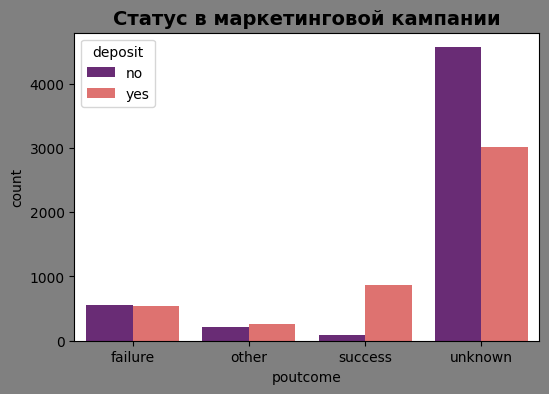

In [27]:
# Построим график статуса маркетинговой кампании
fig, axes = plt.subplots(figsize=(6, 4), facecolor='gray')
sns.barplot(deposit_status, x='poutcome', y='count', hue='deposit', palette='magma')
plt.title('Статус в маркетинговой кампании', fontsize=14, fontweight='bold');

### 2.5. Соотношение открытия / неоткрытия депозита по месяцам

In [28]:
# Группируем признак открытия депозита по признаку месяц
deposit_month = cleaned.groupby('month')['deposit'].value_counts().unstack()
# Процент отказов по месяцам
deposit_month['failure_percent'] = round((deposit_month['no'] / (deposit_month['yes'] + deposit_month['no'])*100), 2)
# Процент согласий по месяцам
deposit_month['success_percent'] = round((deposit_month['yes'] / (deposit_month['yes'] + deposit_month['no'])*100), 2)

deposit_month

deposit,no,yes,failure_percent,success_percent
month,,,,
apr,317,513,38.19,61.81
aug,775,610,55.96,44.04
dec,9,84,9.68,90.32
feb,323,386,45.56,54.44
jan,194,125,60.82,39.18
jul,836,582,58.96,41.04
jun,606,498,54.89,45.11
mar,24,213,10.13,89.87
may,1775,841,67.85,32.15


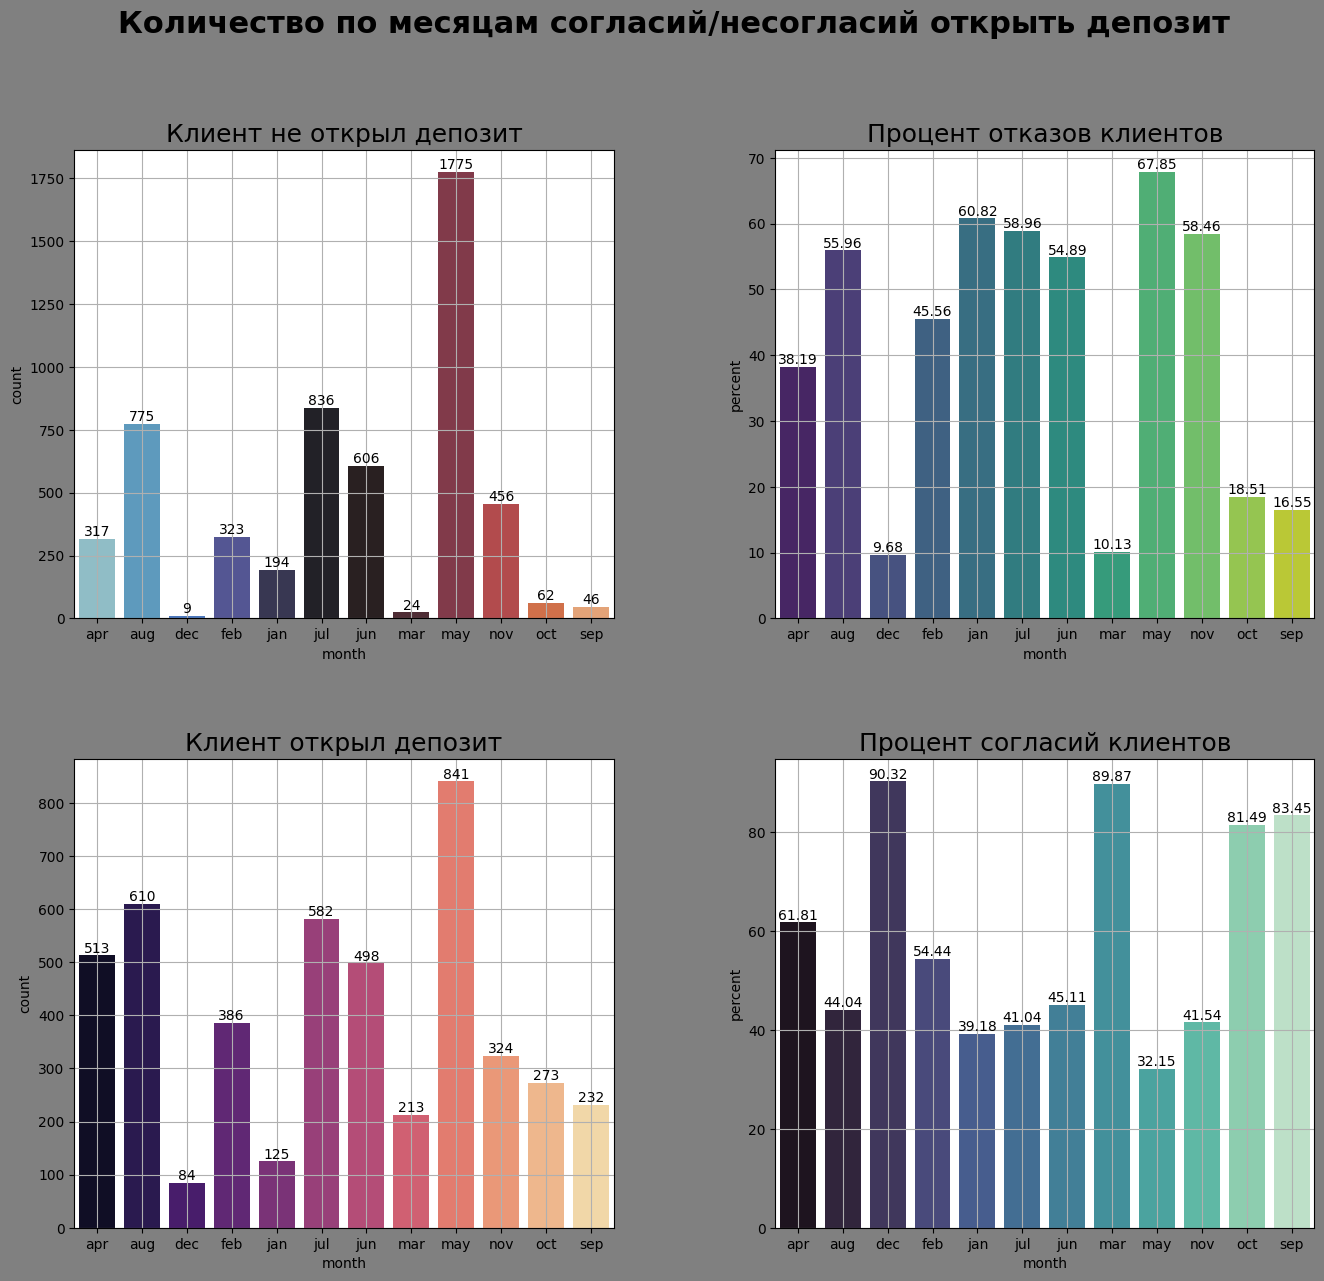

In [29]:
# Задаем поле для графиков 2 х 2.
fig, axes = plt.subplots(2, 2, figsize=(16, 14), facecolor='gray')
fig.suptitle('Количество по месяцам согласий/несогласий открыть депозит',
             fontsize=22,
             fontweight='bold')
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Клиент открыл депозит
bar_yes = sns.barplot(deposit_month,
                      x=deposit_month.index,
                      y=deposit_month['yes'].values,
                      palette='magma',
                      ax=axes[1][0])
# Клиент не открыл депозит
bar_no = sns.barplot(deposit_month,
                     x=deposit_month.index,
                     y=deposit_month['no'].values,
                     palette='icefire',
                     ax=axes[0][0])
# Процент отказов клиентов открыть депозит
bar_percent_no = sns.barplot(deposit_month,
                     x=deposit_month.index,
                     y=deposit_month['failure_percent'].values,
                     palette='viridis',
                     ax=axes[0][1])
# Процент согласий клиентов открыть депозит
bar_percent_yes = sns.barplot(deposit_month,
                     x=deposit_month.index,
                     y=deposit_month['success_percent'].values,
                     palette='mako',
                     ax=axes[1][1])

# Названия графиков
bar_yes.set_title('Клиент открыл депозит', fontsize=18)
bar_no.set_title('Клиент не открыл депозит', fontsize=18)
bar_percent_no.set_title('Процент отказов клиентов', fontsize=18)
bar_percent_yes.set_title('Процент согласий клиентов', fontsize=18)
# Отражаем числовое значение на графиках
bar_yes.bar_label(bar_yes.containers[0])
bar_no.bar_label(bar_no.containers[0])
bar_percent_no.bar_label(bar_percent_no.containers[0])
bar_percent_yes.bar_label(bar_percent_yes.containers[0])
# Изменяем подпись по оси у
bar_yes.set_ylabel('count')
bar_no.set_ylabel('count')
bar_percent_no.set_ylabel('percent')
bar_percent_yes.set_ylabel('percent')
# Сетка на графиках
bar_yes.grid()
bar_no.grid()
bar_percent_no.grid()
bar_percent_yes.grid();

У данного банка активность маркетинговой кампании приходится на май и летние месяцы. На эти же месяцы наблюдается и наибольший процент отказов и максимальное их количество как рав в мае(67,85%). Это можно связать с ростом активности маркетинговой кампании. Но количество отказов от депозита скорее всего связано с праздниками, например, день матери в мае и день отца в июне, день независимости 4 июля. Учитывая категорию клиентов они могут быть не готовы вкладывать деньги накануне праздников.

Процент согласий растет в сентябре и октябре, когда есть возможность сделать краткосрочный вклад перед рождеством. Самый большой процент согласий в декабре, но это связано с тем, что в этом месяце очень низкая общая активность маркетинговой кампании. Если в сентябре при 83% 232 клиента открыли депозит, то в декабре при 90% всего 84.

Также высокий процент согласий приходится на май. Как раз за 2 месяца до начала праздников.

### 2.6. Результат маркетинговой кампании по возрастным группам.

In [30]:
def get_age_group(age):
    '''Функция распределяет возраст клиентов на 5 групп:
    1. до 30 лет
    2. 30-39 лет
    3. 40-49 лет
    4. 50-59 лет
    5. старше 60 лет'''
    if age < 30: return '<30'
    elif 30 <= age < 40: return '30-39'
    elif 40 <= age < 50: return '40-49'
    elif 50 <= age < 60: return '50-59'
    else:
        return '60+'
    
# Создаем признак возрастной группы   
cleaned['age group'] = cleaned['age'].apply(get_age_group)

In [31]:
# Сгруппируем возрастные группы по признаку открытия депозита
age_deposit = cleaned.groupby('deposit')['age group'].value_counts().unstack().T
# Процент, открывших депозит
age_deposit['success percent'] = round((age_deposit['yes'] / (age_deposit['yes'] + age_deposit['no']))*100, 2)
# Процент, отказавшихся открыть депозит
age_deposit['failure percent'] = round((age_deposit['no'] / (age_deposit['yes'] + age_deposit['no']))*100, 2)
age_deposit

deposit,no,yes,success percent,failure percent
age group,,,,
30-39,2245,1716,43.32,56.68
40-49,1443,938,39.40,60.60
50-59,984,670,40.51,59.49
60+,157,496,75.96,24.04
<30,594,861,59.18,40.82


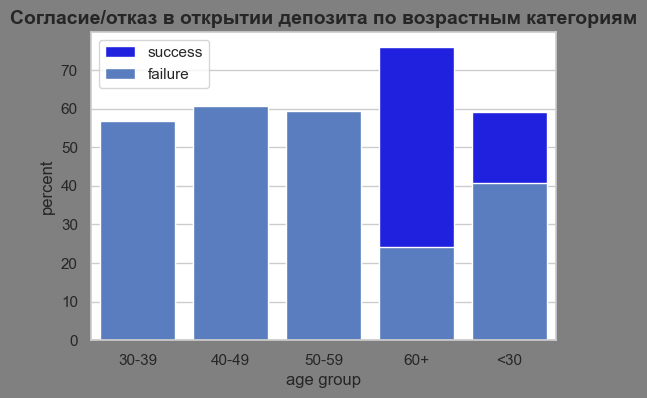

In [121]:
# Задаем пространство для графика
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(figsize=(6, 4), facecolor='gray')
sns.set_color_codes('pastel')
# Barplot открывших депозит
sns.barplot(age_deposit,
            x=age_deposit.index,
            y=age_deposit['success percent'],
            label='success',
            color='blue')
sns.set_color_codes('muted')
# Barplot отказавшихся открыть депозит
sns.barplot(age_deposit,
            x=age_deposit.index,
            y=age_deposit['failure percent'],
            label='failure',
            color='b')
plt.title('Согласие/отказ в открытии депозита по возрастным категориям',
          fontsize=14,
          fontweight='bold');
plt.ylabel('percent');
plt.legend();

В данном случае нас интереуют возрастные категории, в которых положительный исход маркетинговой кампании выше, чем ее неуспех.

С положительным успехом маркетинговая кампания проходит среди клиентов в категории 60+ и до 30 лет. Но ниабольшее число клиетов банка находится в категории 30-39 лет. 

### 2.7. Результат маркетинговой кампании в зависимости от семейного статуса, уровня образования и сферы занятости

In [33]:
# Сгруппируем семейный статус клиентов по резульатам кампании
deposit_marital = cleaned.groupby(by='deposit', as_index=False)['marital'].value_counts()
# Сгруппируем уровень образования клиентов по резульатам кампании
deposit_edu = cleaned.groupby(by='deposit', as_index=False)['education'].value_counts()
# Сгруппируем сферу деятельности клиентов по резульатам кампании
deposit_job = cleaned.groupby(by='deposit', as_index=False)['job'].value_counts()

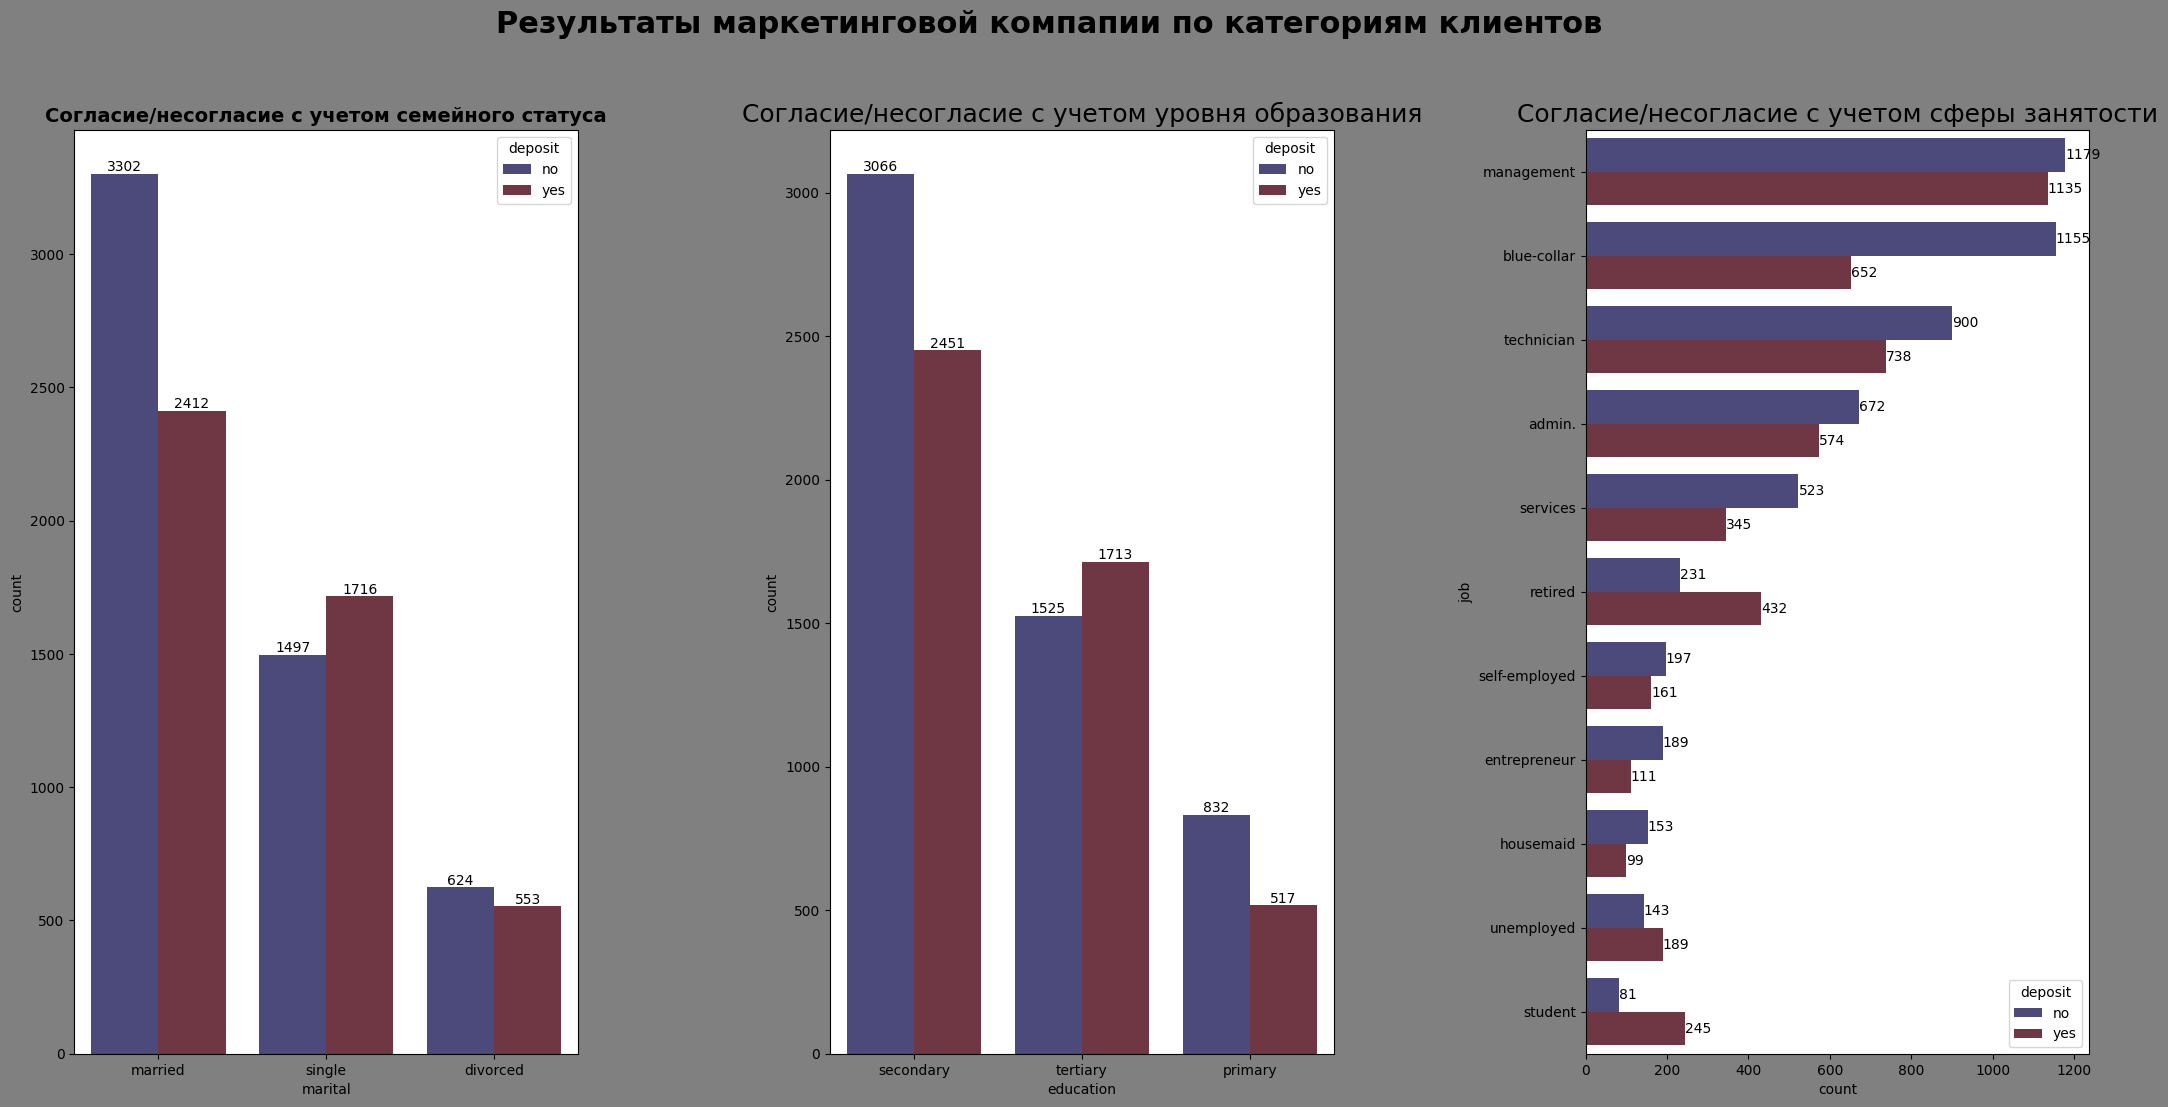

In [34]:
# Построим пространство для графиков 1 х 3
fig, axes = plt.subplots(1, 3, figsize=(26, 12), facecolor='gray')
plt.subplots_adjust(wspace=0.5)
plt.suptitle('Результаты маркетинговой компапии по категориям клиентов',
             fontsize=22,
             fontweight='bold')
# Barplot семейный статус
bar_marital = sns.barplot(deposit_marital,
            x='marital',
            y='count',
            hue='deposit',
            palette='icefire',
            ax=axes[0])
bar_marital.set_title('Согласие/несогласие с учетом семейного статуса',
            fontsize=14,
            fontweight='bold')
bar_marital.bar_label(bar_marital.containers[0])
bar_marital.bar_label(bar_marital.containers[1]);

# Barplot уровень образования
bar_edu = sns.barplot(deposit_edu,
            x='education',
            y='count',
            hue='deposit',
            palette='icefire',
            ax=axes[1])
bar_edu.set_title('Согласие/несогласие с учетом уровня образования', fontsize=18)
bar_edu.bar_label(bar_edu.containers[0])
bar_edu.bar_label(bar_edu.containers[1])

# Barplot сфера деятельности
bar_job = sns.barplot(deposit_job,
            y='job',
            x='count',
            hue='deposit',
            palette='icefire',
            ax=axes[2])
bar_job.set_title('Согласие/несогласие с учетом сферы занятости', fontsize=18)
bar_job.bar_label(bar_job.containers[0])
bar_job.bar_label(bar_job.containers[1]);

По сферам занятости склонны соглашаться с предложениями банка пенсионеры, безработные, студенты. Большое количество согласий у менеджеров, технического персонала, администраторов, но отказов в этих категоряих незначительно больше.

Значительное различие в категорях в пользу отказов у рабочих и служащих.

По признаку уровня образования склонны соглашаться спредложениями банка клиенты, находящиеся на третьей ступени образования. У большей части клиентов со второй ступенью количество отказов превышает количество согласий.

По признаку семейного положения большее количество положительных исходов маркетинговой кампании среди одиноких клиентов. Среди клиентов, состоящих в браке, доля отказов выше.

Постмотрим на зависимость количества клиентов открывших и не открывших депозит, относительно уровня образования и семейного статуса

In [35]:
# Сводная таблица для открывших депозит по образованию и семейному статусу
mask = cleaned['deposit'] == 'yes'
deposit_success = pd.pivot_table(
    data=cleaned[mask],
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

# Сводная таблица для не открывших депозит по образованию и семейному статусу
mask = cleaned['deposit'] == 'no'
deposit_failure = pd.pivot_table(
    data=cleaned[mask],
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)
display(deposit_success, deposit_failure)

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,831
single,100,866,531


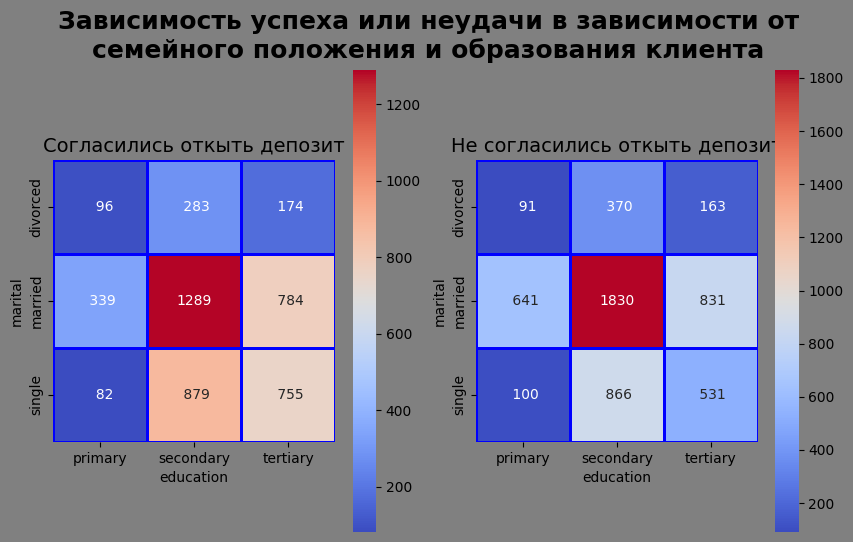

In [36]:
# Поле для графиков размером 1 х 2
fig, axes = plt.subplots(1, 2, figsize=(10, 6), facecolor='gray')
plt.suptitle('''Зависимость успеха или неудачи в зависимости от
семейного положения и образования клиента''',
   fontsize=18,
   fontweight='bold')
# Тепловая карта по клиентам открывшим депозит
heatmap_success = sns.heatmap(deposit_success,
                              annot=True,
                              fmt='4',
                              square=True,
                              cmap='coolwarm',
                              linecolor='blue',
                              linewidths=2,
                              ax=axes[0])
heatmap_success.set_title('Согласились откыть депозит', fontsize=14)

# Тепловая карта по клиентам не открывшим депозит
heatmap_failure = sns.heatmap(deposit_failure,
                              annot=True,
                              fmt='4',
                              square=True,
                              cmap='coolwarm',
                              linecolor='blue',
                              linewidths=2,
                              ax=axes[1]
                              )
heatmap_failure.set_title('Не согласились откыть депозит', fontsize=14);

Наиболее популярные группы среди клиентов, которые открыли и не открыли депозит не различаются - это клиенты со второй ступенью образования, состоящие в браке. Эта категория клиентов банка самая многочисленная. Примерно равный баланс у одиноких клиентов со второй ступенью образования. 

Но у одиноких клиентов с третьей ступенью образования, хоть и не большое количество согласий, но и меньшая доля отказова. Эта группа среди клиентов банка немногочисленна.

Среди разведенных клиентов, а также одиноких с первичной ступенью образования самые низкие показатели. Имеющиеся банка, видимо, им не интересны.

Большая часть клиентов банка в возрасте 30-50 лет, окончившие старшую школу, состоящие в браке. Их сфера деятельности - менеджмент, рабочие профессии, технический персонал, администраторы, служащие. У них редки просрочки по кредитам и редко берут кредит на личные нужды. Наличие или отсутствие кредита на жилье находится примерно в равных долях.

Клиенты, которые чаще соглашаются на предложения банка находятся в двух возрастных категориях - старше 60 лет и до 30 лет. Это люди, не состоящие в браке, прошедшие третью ступень образования, которые в настоящий момент находятся на пенисии, либо являются студентами или безработными.

## <center> **3. Преобразование данных**

Сбросим индексы, оставшиеся после удаления выбросов

In [37]:
cleaned = cleaned.reset_index().rename(columns={'index' : 'old index'})
cleaned

,old index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age group
0,0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-59
1,1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-59
2,2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-49
3,3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-59
4,4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10099,11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-39
10100,11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-39
10101,11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-39
10102,11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-49


In [38]:
cleaned = cleaned.drop('old index', axis=1)

### 3.1. Кодирование признаков

Label Encoder - это метод, который используется для преобразования категориальных столбцов в числовые, чтобы они могли соответствовать моделям машинного обучения, которые принимают только числовые данные. Он присваивает каждой категории в признаке значение от 0 до $n$, где $n$ - количество категорий.

In [39]:
# Преобразуем уровни образования
encoder = LabelEncoder()
lb_encoder = encoder.fit_transform(cleaned['education'])
cleaned['education encode'] = lb_encoder

In [40]:
# Преобразуем возрастные группы
encoder = LabelEncoder()
lb_encoder = encoder.fit_transform(cleaned['age group'])
cleaned['age group encode'] = lb_encoder

In [41]:
# Удаляем признаки, которые преобразовывали
cleaned = cleaned.drop(['education', 'age group'], axis=1)

Преобразуем переменную 'deposit' в представление из нулей и единиц, где 1 - 'yes', а 0 - 'no'.

In [42]:
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

Преобразуем оставшиеся бинарные признаки по тому же принципу

In [43]:
# Список признаков, в которых количество уникальных значений равно 2
bynary_list = [x for x in cleaned.columns if cleaned[x].nunique() == 2]
bynary_list.remove('deposit') # Удаляем целевой признак
# Производим преобразование в цикле
for feature in bynary_list:
    cleaned[feature] = cleaned[feature].apply(lambda x: 1 if x == 'yes' else 0)

Категориальные признаки закодируем методом OneHotEncoder, используя функцию pandas get_dummies. Для каждой категории создается отдельный признак, где результат кодируется как 1 или 0.

In [44]:
# Список категориальных признаков
nominal_list = [x for x in cleaned.columns if cleaned[x].dtype == 'object']
print(nominal_list)
# Создаем dummy-признаки в новом датафрейме
dummy_cleaned = pd.get_dummies(cleaned[nominal_list])
# Соединяем датафреймы
cleaned = pd.concat([cleaned, dummy_cleaned], axis=1)

['job', 'marital', 'contact', 'month', 'poutcome']


In [45]:
# Удаляем признаки, которые кодировали
cleaned = cleaned.drop(nominal_list, axis=1)

### 3.2. Анализ корреляции признаков

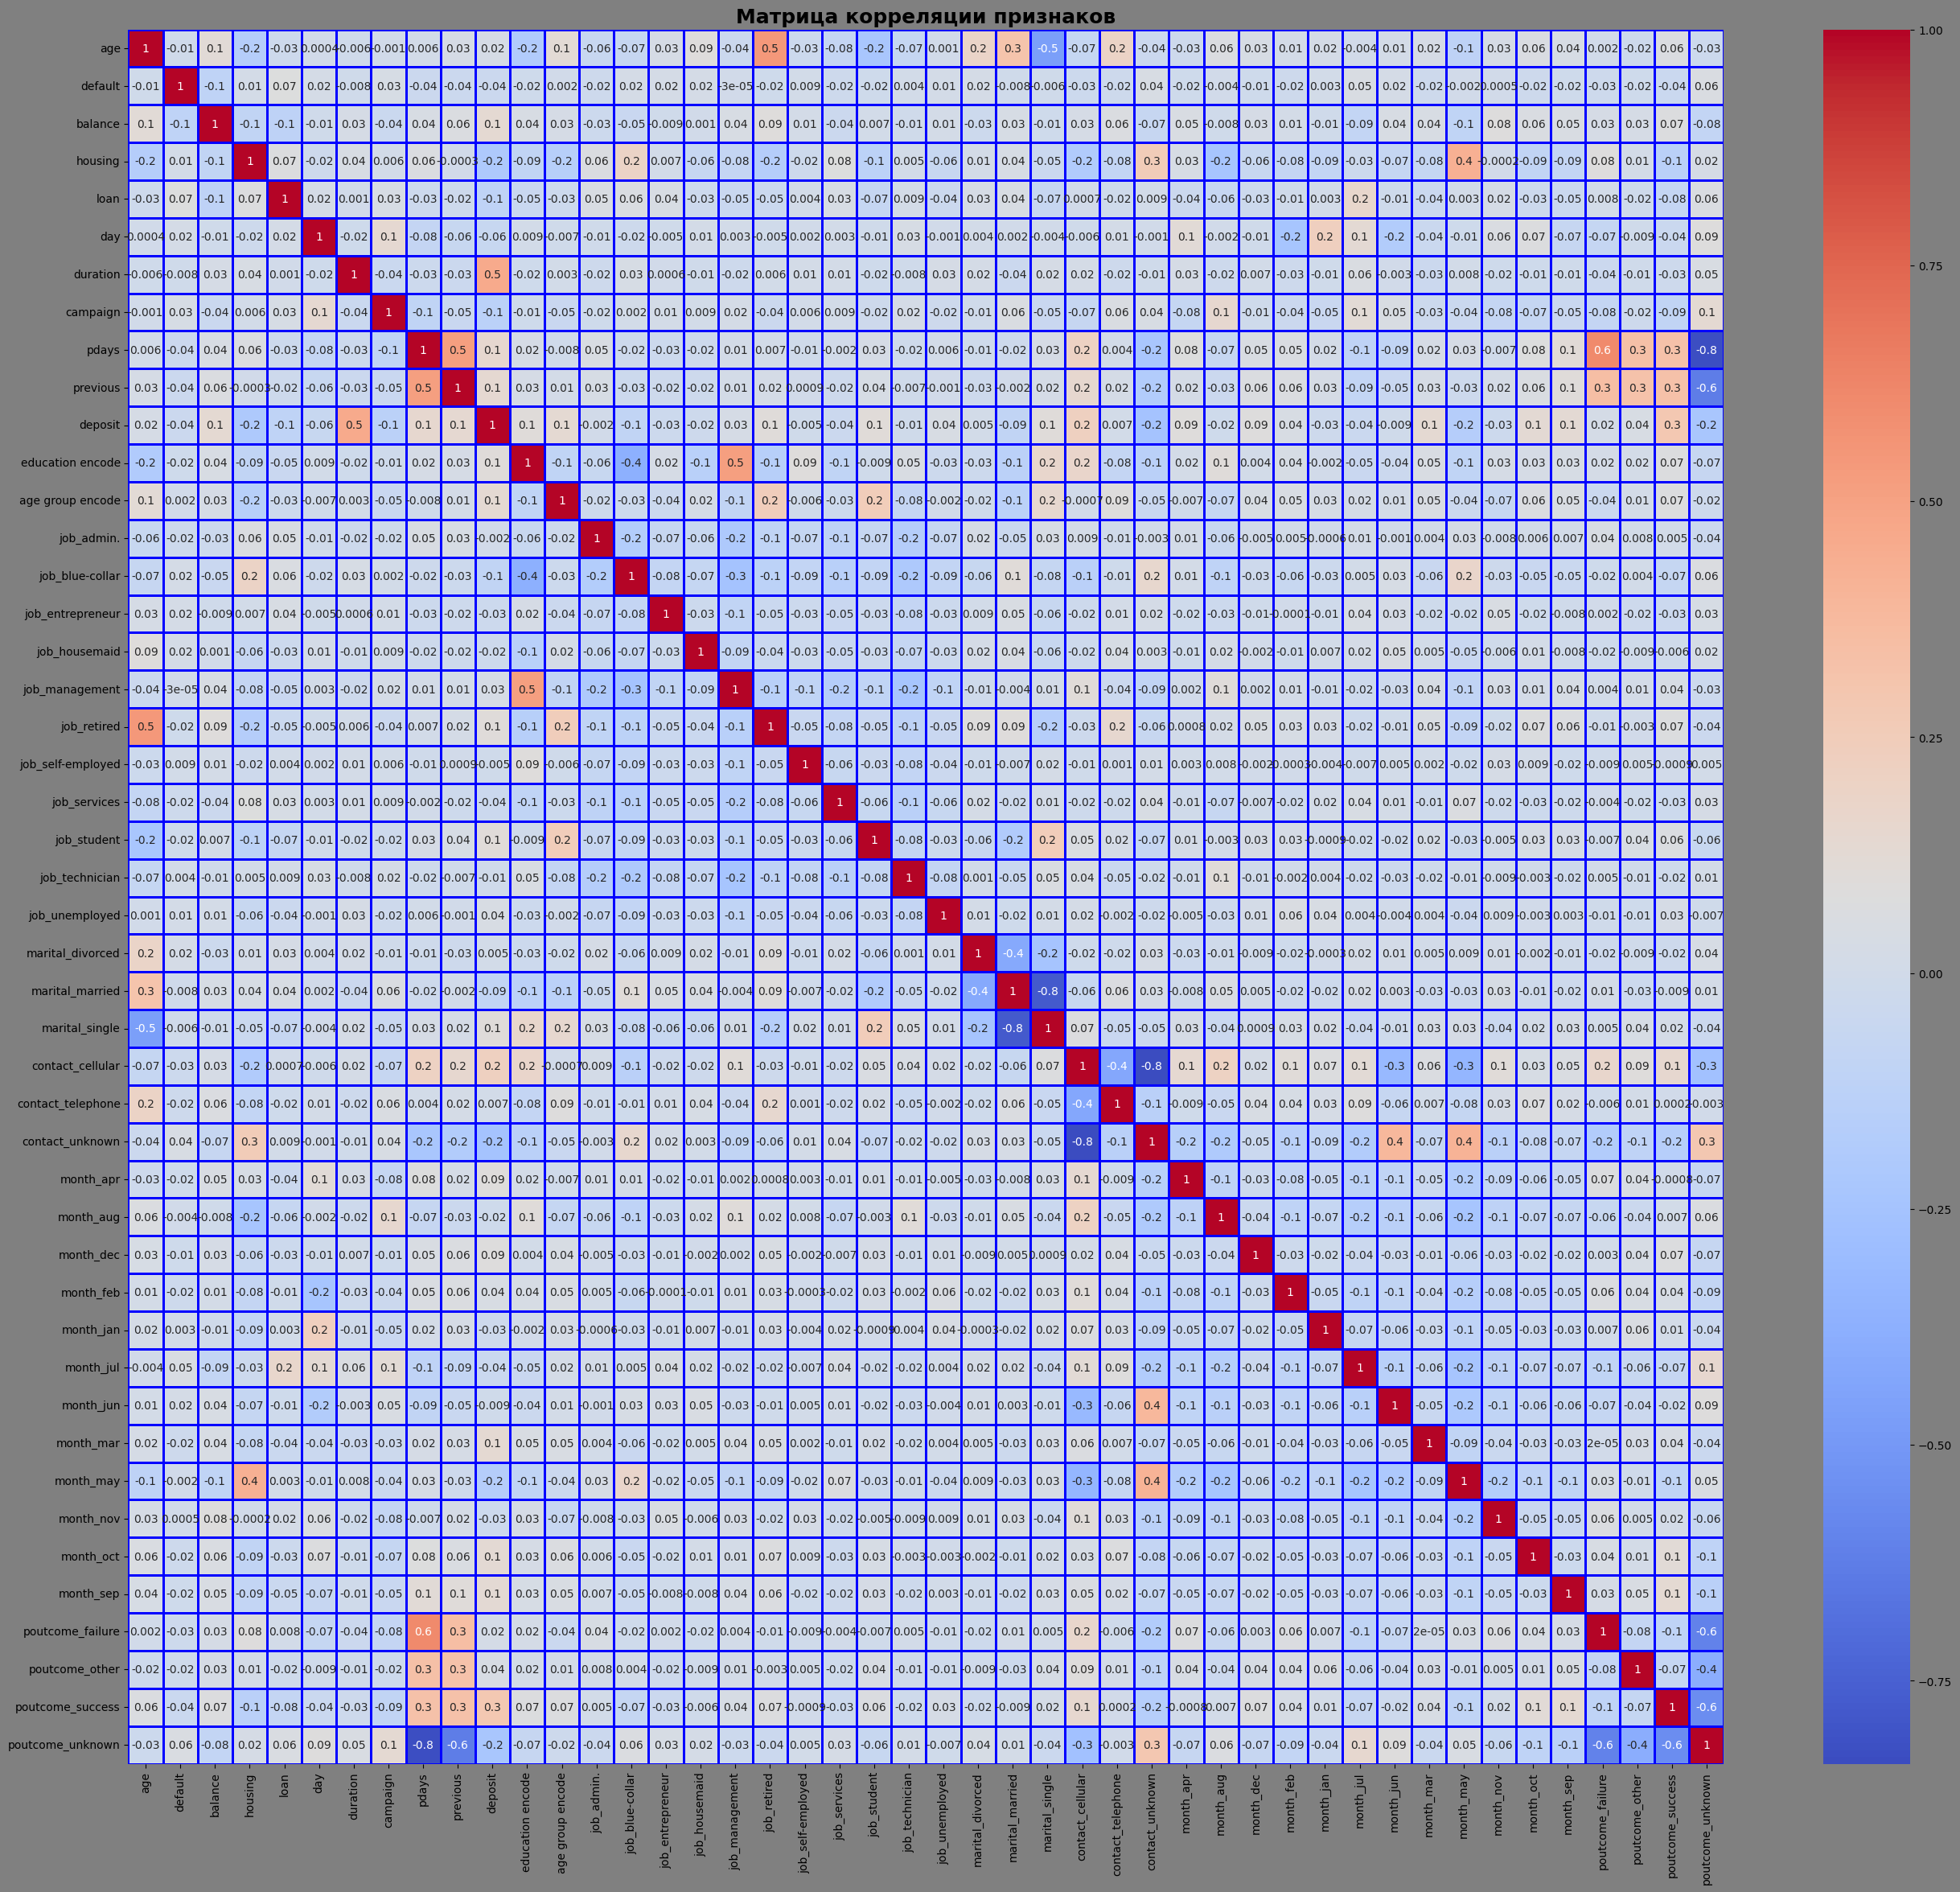

In [46]:
# Постороим матрицу корреляции признаков
plt.figure(figsize=(32, 28), facecolor='gray')
sns.heatmap(cleaned.corr(),
            annot=True,
            fmt='.1g',
            cmap='coolwarm',
            linecolor='blue',
            linewidths=1)
plt.title('Матрица корреляции признаков',
          fontsize=18,
          fontweight='bold');

Возьмем за уровень мультиколлениарности коэффициент корреляции 0.9. Таких признаков в датасете нет. Самый высоки коэффициент корреляции - 0.8.

In [47]:
# Посмотрим на коэффициенты корреляции признаков с целевой переменной
corr_matrix = round(cleaned.corr(), 2)
corr_matrix['deposit'].sort_values(ascending=False).reset_index().rename(columns={'index' : 'feature', 'deposit' : 'coeff'})

,feature,coeff
0,deposit,1.00
1,duration,0.46
2,poutcome_success,0.29
3,contact_cellular,0.22
4,pdays,0.15
5,balance,0.14
6,previous,0.14
7,month_mar,0.14
8,age group encode,0.14
9,month_oct,0.13


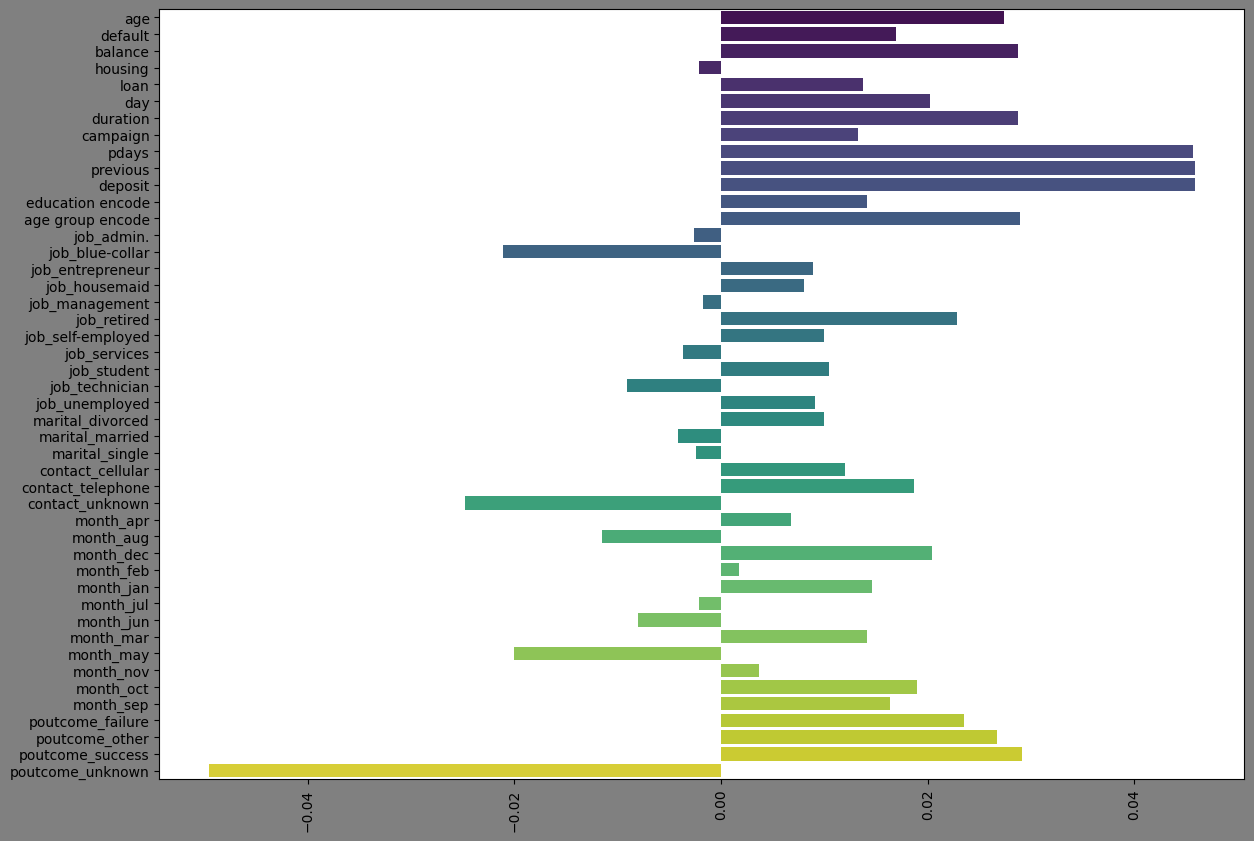

In [48]:
# Отразим полученные коэффициентв на графике
plt.figure(figsize=(14, 10), facecolor='gray')

bar = sns.barplot(corr_matrix,                                  
                  palette='viridis',
                  orient='h',
                  errorbar=None)
bar.xaxis.set_tick_params(rotation=90)
# bar.set_ylim(-1, 1)


### 3.3. Подготовка датасета, отбор признаков

In [49]:
# Выделим из датасета целевую переменную у
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
# Разделим данные на обучающую и тестовую выборки в соотношении 0.33 
# с сохранением баланса классов по целевой переменной 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [50]:
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер тестовой выборки: 3335


Отберем значимые для обучения признаки, используя статсистические фильтры. В данном случае применим корреляцию Пирсона.

In [62]:
# С помощью SelectKBest отберем 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
features_15 = selector.get_feature_names_out()
print(f'15 наиболее значимых признаков для обучения: {features_15}')  

15 наиболее значимых признаков для обучения: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous'
 'age group encode' 'contact_cellular' 'contact_unknown' 'month_mar'
 'month_may' 'month_oct' 'month_sep' 'poutcome_success' 'poutcome_unknown']


### 3.4. Нормализация признаков

При применении нормализации методом MinMaxScaler все значения признаков будут преобразованы в диапазон [0,1], что означает, что минимальное и максимальное значение признака будет равно 0 и 1 соответственно.

Нормализация происходит следующим способом:

Из каждого значения признака х вычитается минимальное значение этого признака: 
$x - min$ 
Результат вычитания делится на разность между максимумом и минимумом признака: 
$max - min$

 $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$

Это нужно для того, чтобы признаки, которые находятся в разных масштабах не влияли на обучение модели.

In [63]:
# Инциализируем minmaxsxaler
scaler = preprocessing.MinMaxScaler()
# Обучим тренировочную выборку
scaler.fit(X_train[features_15])
# Преобразуем тренировочную и тестовую выборки
X_train_scal = scaler.transform(X_train[features_15])
X_test_scal = scaler.transform(X_test[features_15])

## <center> **4. Решение задачи классификации: логистическая регрессия и решающие деревья**

### 4.1. Метрики классификации

**Accuracy (достоверность)** — доля правильных ответов модели среди всех ответов. Правильные ответы — это истинно положительные (True Positive) и истинно отрицательные ответы (True Negative):

$accuracy = \frac{TP + TN}{TP + TN + FN + FP}$

**Precision (точность), или PPV (Positive Predictive Value)** — это доля объектов, которые действительно являются положительными, по отношению ко всем объектам, названным моделью положительными.

$precision = \frac{TP}{TP+FP}$

**Recall (полнота), или TPR (True Positive Rate)** — это доля объектов, названных классификатором положительными, по отношению ко всем объектам положительного класса.

$recall = \frac{TP}{TP + FN}$

**$F_{\beta}$** - это взвешенное среднее гармоническое между precision и recall:

$F_{\beta} = (1+\beta^{2})\frac{precision \cdot recall}{(\beta^{2} precision) + recall}$

### 4.2. Логистическая регрессия

In [73]:
# Создаем объект класса логистическая регрессия
model_log_reg = linear_model.LogisticRegression(random_state=42,
                                                max_iter=1000,
                                                solver='sag')
# Обучаем модель
model_log_reg.fit(X_train_scal, y_train)
# Предсказываем значения по обучающей и тестовой выборкам
y_train_pred = model_log_reg.predict(X_train_scal)
y_test_pred = model_log_reg.predict(X_test_scal)
# Значения метрик
def get_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('Train:', metrics.classification_report(y_train, y_train_pred))
    print('-'*60)
    print('Test:', metrics.classification_report(y_test, y_test_pred))
    
get_metrics(y_train, y_train_pred, y_test, y_test_pred)  

Train:               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3633
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6769
   macro avg       0.83      0.82      0.82      6769
weighted avg       0.83      0.82      0.82      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335



### 4.3. Деревья решений

In [74]:
# Создаем модель классификатора дерева решений
model_dt = tree.DecisionTreeClassifier(random_state=42,
                                       max_depth=5,
                                       criterion='entropy')
# Обучаем модель
model_dt.fit(X_train_scal, y_train)
# Предсказываем значения на тренировочной и тестовой выборках
y_train_pred = model_dt.predict(X_train_scal)
y_test_pred = model_dt.predict(X_test_scal)
# Значения метрик
get_metrics(y_train, y_train_pred, y_test, y_test_pred) 

Train:               precision    recall  f1-score   support

           0       0.86      0.76      0.81      3633
           1       0.75      0.86      0.80      3136

    accuracy                           0.80      6769
   macro avg       0.81      0.81      0.80      6769
weighted avg       0.81      0.80      0.80      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1790
           1       0.75      0.84      0.79      1545

    accuracy                           0.79      3335
   macro avg       0.80      0.80      0.79      3335
weighted avg       0.80      0.79      0.79      3335



#### Подбор гиперпараметров методом gridsearch

In [76]:
# Составим сетку гиперпараметров
param_grid = {'min_samples_split': [2, 5, 7, 10], # Минимальное количество выборок для рахделения
              'max_depth':[3,5,7, ] # Максимальная глубина дерева
              }
# Создаем объект gridsearch
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    n_jobs=-1
)
# Обучаем модель
%time grid_search.fit(X_train_scal, y_train)
# Лучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print()
# Значения метрик
get_metrics(y_train, y_train_pred, y_test, y_test_pred) 

CPU times: total: 594 ms
Wall time: 4.02 s
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}

Train:               precision    recall  f1-score   support

           0       0.86      0.76      0.81      3633
           1       0.75      0.86      0.80      3136

    accuracy                           0.80      6769
   macro avg       0.81      0.81      0.80      6769
weighted avg       0.81      0.80      0.80      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1790
           1       0.75      0.84      0.79      1545

    accuracy                           0.79      3335
   macro avg       0.80      0.80      0.79      3335
weighted avg       0.80      0.79      0.79      3335



## <center> **5. Решение задачи классификации: ансамбли моделей**

### 5.1. Бэггинг: Случайный лес

In [85]:
# Создаем модель RandomForestClassifier
model_rf = ensemble.RandomForestClassifier(random_state=42,
                                           n_estimators=100, # Количество деревьев
                                           criterion='gini', # Кртерий информативности
                                           min_samples_leaf=5, # Минимальное количество объектов на листе
                                           max_depth=10) # Максимальная глубина дерева

# Обучаем модель
%time model_rf.fit(X_train_scal, y_train)
# Предсказываем значения обучающей и тестовой выборок
y_train_pred = model_rf.predict(X_train_scal)
y_test_pred = model_rf.predict(X_test_scal)
# Значения метрик
get_metrics(y_train, y_train_pred, y_test, y_test_pred) 

CPU times: total: 4.14 s
Wall time: 4.29 s
Train:               precision    recall  f1-score   support

           0       0.88      0.85      0.87      3633
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6769
   macro avg       0.86      0.86      0.86      6769
weighted avg       0.86      0.86      0.86      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### 5.2. Бустинг: градиентный бустинг

In [86]:
# Создаем объект GradientBoostingClassifier
model_gb = ensemble.GradientBoostingClassifier(random_state=42,
                                               learning_rate=0.05, # Скорость обучения
                                               n_estimators=300, # Количество деревьев
                                               min_samples_leaf=5, # Минимальное количество объектов на листе
                                               max_depth=5) # Максимальная глубина дерева

# Обучаем модель
%time model_gb.fit(X_train_scal, y_train)
# Предсказываем значения обучающей и тестовой выборок
y_train_pred = model_gb.predict(X_train_scal)
y_test_pred = model_gb.predict(X_test_scal)
# Значения метрик
get_metrics(y_train, y_train_pred, y_test, y_test_pred) 

CPU times: total: 3min 6s
Wall time: 3min 13s
Train:               precision    recall  f1-score   support

           0       0.91      0.88      0.89      3633
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6769
   macro avg       0.89      0.89      0.89      6769
weighted avg       0.89      0.89      0.89      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### 5.3. Стекинг

In [87]:
# Объединим созданные модели алгоритмом стекинга
# В качестве метамодели используем логистическую регрессию 
# Создаем список моделей
estimators = [('lr', linear_model.LogisticRegression(random_state=42,
                                                     max_iter=1000,
                                                     solver='sag')),
              ('dt', tree.DecisionTreeClassifier(random_state=42,
                                                max_depth=5,
                                                criterion='entropy')),
              ('rf', ensemble.RandomForestClassifier(random_state=42,
                                                     n_estimators=100,
                                                     criterion='gini',
                                                     min_samples_leaf=5,
                                                     max_depth=10)),
              ('gb', ensemble.GradientBoostingClassifier(random_state=42,
                                                         learning_rate=0.05,
                                                         n_estimators=300,
                                                         min_samples_leaf=5,
                                                         max_depth=5))
]

# Создаем объект StackingClassifier
model_st = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42,
                                                     max_iter=1000,
                                                     solver='sag')  
)

# Обучаем модель
%time model_st.fit(X_train_scal, y_train)
# Предсказываем значения обучающей и тестовой выборок
y_train_pred = model_gb.predict(X_train_scal)
y_test_pred = model_gb.predict(X_test_scal)
# Значения метрик
get_metrics(y_train, y_train_pred, y_test, y_test_pred) 

CPU times: total: 10min 36s
Wall time: 10min 43s
Train:               precision    recall  f1-score   support

           0       0.91      0.88      0.89      3633
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6769
   macro avg       0.89      0.89      0.89      6769
weighted avg       0.89      0.89      0.89      6769

------------------------------------------------------------
Test:               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Модели на основе алгоритмов стекинга и бустинга показали себя лучше других. Для итоговой модели используем алгоритм градиентного бустинга, так как в нем подели обучаются последовательно нивилируя ошибки предыдущих моделей.

### 5.4. Оптимизация гиперпараметров модели градиентного бустинга с помощью Optuna

Оценим значимость признаков для обучения модели градиентного бустинга

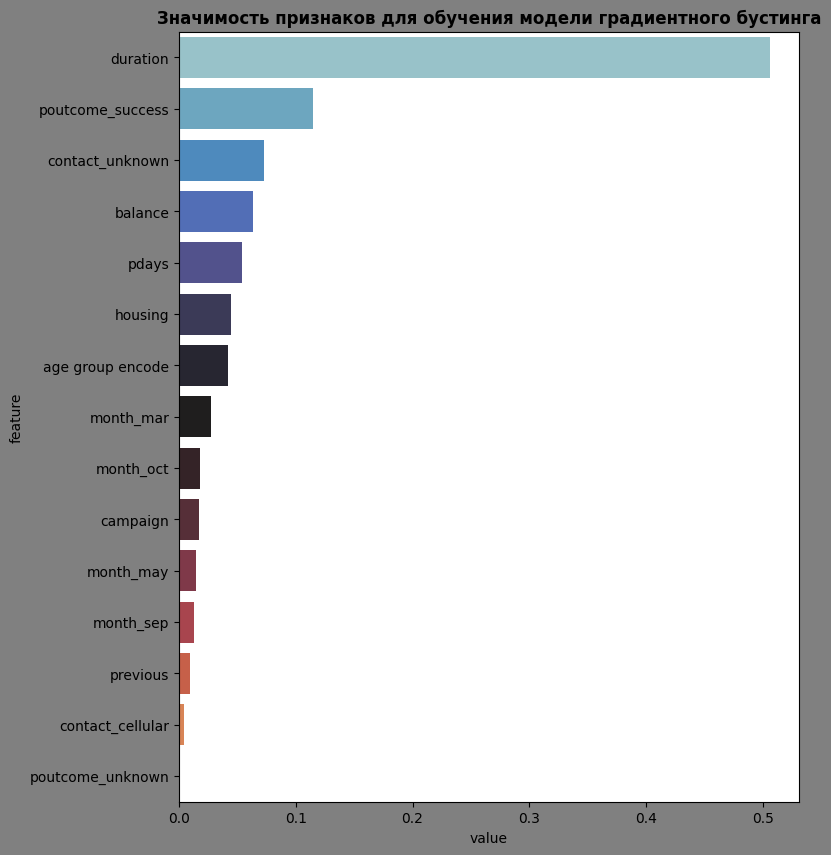

In [88]:
# Создадим объект Series, содержащий иерархию значимых признаков
feature_importances = pd.Series(model_gb.feature_importances_, index=X_train[features_15].columns).\
    sort_values(ascending=False).reset_index().rename(columns={'index' : 'feature', 0 : 'value'})
# Построим Barplot значимых признаков
fig=plt.figure(figsize=(8, 10), facecolor='gray')
bar = sns.barplot(feature_importances,
                  x='value',
                  y='feature',
                  palette='icefire')
bar.set_title('Значимость признаков для обучения модели градиентного бустинга',
              fontweight='bold');

In [93]:
# Функция реализует обучение модели с подбором гиперпараметров
def optuna_rf(trial):
  # Задаем пространство поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # Создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # Обучаем модель
  model.fit(X_train_scal, y_train)
  # Сохраняем метрику f1, обучая на кросс-валидации с разбивкой на 5 фолдов
  score = cross_val_score(model, X_train_scal, y_train, scoring='f1', cv=5, n_jobs=-1)
  # score = metrics.f1_score(y_train, model.predict(X_train_scal))
  # Возвращаем среднее значение по метрикам на кросс-валидации
  return score.mean()

In [94]:
%%time
# Создаем объект исследования
# Максимизируем метрику direction='maximize'
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-07-20 08:36:41,990] A new study created in memory with name: RandomForestClassifier
[I 2023-07-20 08:36:52,797] Trial 0 finished with value: 0.8232079065776725 and parameters: {'n_estimators': 127, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8232079065776725.
[I 2023-07-20 08:37:10,007] Trial 1 finished with value: 0.8237298379259856 and parameters: {'n_estimators': 162, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8237298379259856.
[I 2023-07-20 08:37:22,159] Trial 2 finished with value: 0.8231183505081697 and parameters: {'n_estimators': 118, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8237298379259856.
[I 2023-07-20 08:37:37,751] Trial 3 finished with value: 0.8230700269456463 and parameters: {'n_estimators': 161, 'max_depth': 12, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8237298379259856.
[I 2023-07-20 08:37:49,206] Trial 4 finished with value: 0.82366571131802 and parameters: {'n_es

CPU times: total: 56.1 s
Wall time: 2min 10s


Значения метрики почти не изменяются. Проведем еще 10 итераций.

In [95]:
%%time
study.optimize(optuna_rf, n_trials=10)

[I 2023-07-20 08:40:10,396] Trial 10 finished with value: 0.8247962250430314 and parameters: {'n_estimators': 188, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.8247962250430314.
[I 2023-07-20 08:40:26,832] Trial 11 finished with value: 0.8252121494275453 and parameters: {'n_estimators': 173, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.8252121494275453.
[I 2023-07-20 08:40:45,988] Trial 12 finished with value: 0.82392979392229 and parameters: {'n_estimators': 194, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.8252121494275453.
[I 2023-07-20 08:41:04,311] Trial 13 finished with value: 0.8241049837263992 and parameters: {'n_estimators': 190, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 11 with value: 0.8252121494275453.
[I 2023-07-20 08:41:22,091] Trial 14 finished with value: 0.8258115683125157 and parameters: {'n_estimators': 178, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 14 with valu

CPU times: total: 1min 13s
Wall time: 2min 52s


In [97]:
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {round(study.best_value, 2)}')

Наилучшие значения гиперпараметров {'n_estimators': 177, 'max_depth': 16, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.83


In [98]:
# Рассчитаем метрику для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train_scal, y_train)
y_train_pred = model.predict(X_train_scal)
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred), 2)}')

f1_score на тестовом наборе: 0.82


In [99]:
# Визуализируем процесс подбора гиперпараметров
optuna.visualization.plot_optimization_history(study, target_name='f1_score')

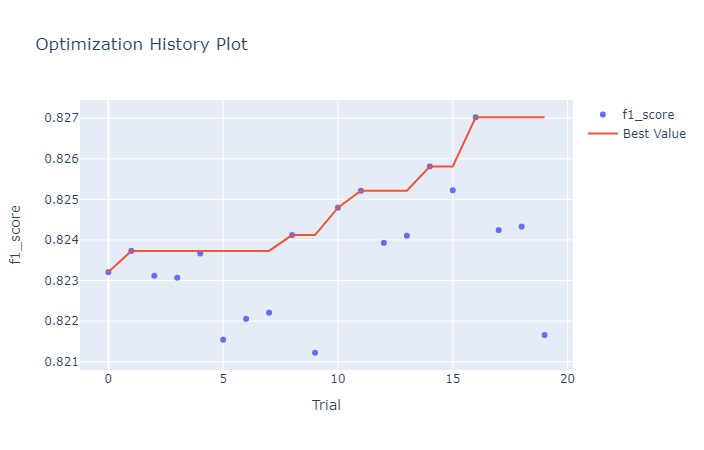

In [100]:
# Построим график значимых гиперпараметров
optuna.visualization.plot_param_importances(study, target_name='f1_score')

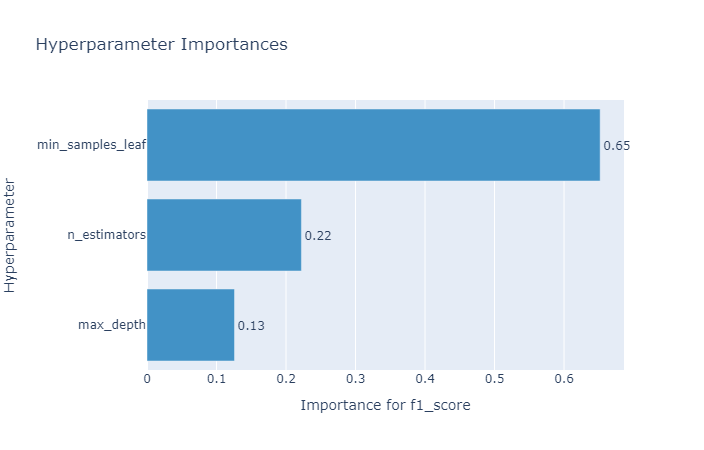

## <center> **6. Заключение**

Лучшие результаты для решения задачи показала модель на основе алгоритма градиентного бустинга. В данном случае нам важно сохранить баланс между метриками precision и recall, то есть сбаланисровать ложноположительные и ложноотницательные срабатывания. Для тестовой выборки F-мера равна 0.82. В идеальном состоянии метрика стремится к значению 1.

Соотношение метрик на тренировочной и тестовой выборках говорит об отсутствии как переобучения, так и недообучения модели.

Для увеличения количества клиентов, которые открывают депозит в банке во время маркетинговой кампании можно обратить внимание на категории клиентов, которые не являются многочисленными.

Клиенты, которые чаще соглашаются на предложения банка находятся в двух возрастных категориях - старше 60 лет и до 30 лет. Это люди, не состоящие в браке, прошедшие третью ступень образования, которые в настоящий момент находятся на пенисии, либо являются студентами или безработными.

Также можно попробовать другие сроки активности маркетиноговой кампании. 

Процент согласий растет в сентябре и октябре, когда есть возможность сделать краткосрочный вклад перед рождеством. Самый большой процент согласий в декабре, но это связано с тем, что в этом месяце очень низкая общая активность маркетинговой кампании. Если в сентябре при 83% 232 клиента открыли депозит, то в декабре при 90% всего 84. Также высокий процент согласий приходится на май. Как раз за 2 месяца до начала праздников.